In [13]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import evaluations as ev

import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1


    
    

def iter_list(log_dir):
    dirlist = os.listdir(log_dir)
    iterlist = []
    for mydir in dirlist:
        if 'iter' in mydir and 'tmp' not in mydir:
            iterlist.append(int(mydir.split('_')[-1]))
    return np.array(iterlist)
    
    
def load_model(model, log_dir, iters, latest=False):
    print(f"""{log_dir} \n snapshot_model_iter_{iters}""")
    if latest == True:
        iters = np.max(iter_list(log_dir))
    model.load_state_dict(torch.load(os.path.join(log_dir, 'snapshot_model_iter_{}'.format(iters))))
    #model.load_state_dict(torch.load(os.path.join(log_dir, 'snapshot_manager_iter_{}'.format(iters))))




def load_config(targdir_path):
    targ_config_path = os.path.join(targdir_path, 'config.yml')
    with open(targ_config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config
    
    
def filter_names(query, mydict):
    filtered = {} 
    for key in mydict.keys():
        if query in key:
            filtered[key] = mydict[key]
    return filtered
    
def filter_list(query, mylist):
    filtered = [] 
    for key in mylist:
        if query in key:
            filtered.append(key)
    return filtered


def model_exists(targlist,  targpath):
    filtered_list = []
    for targdir in targlist:
        if os.path.exists(os.path.join(targpath, targdir, 'config.yml')):
            filtered_list.append(targdir)
    return filtered_list
    
    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
jobdir = '/mnt/vol21/masomatics/ULASclone/jobs'

mode = 'so3'
dat_root = f"""/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/{mode}"""

baseline_path = os.path.join(result_dir, '20220615_default_run_mnist')
basestar_path = os.path.join(result_dir, '20220615_NeuralMstar_neuralM_vanilla')
playground_path = os.path.join(result_dir, '20220913_playground_model')
print(baseline_path)
print(os.path.exists(baseline_path))
print(os.path.exists(basestar_path))
print(os.path.exists(playground_path))



filter_list('202209', os.listdir(result_dir))

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist
True
True
True


['20220901_Mstar_inv_reg_cnn_0',
 '20220908_lstsq_Mdetach_0',
 '20220926_latentPredict_rerun_0',
 '20220909_latentPredict_zero_0',
 '20220908_latentPredict_bg_0',
 '20220901_Mstar_orth_0',
 '20220926_default_run_mnist',
 '20220907_latentPredict_0',
 '20220929_latentPred_0',
 '20220913_default_run_again_0',
 '20220913_playground_model']

In [14]:
#projname = 'default_run_again'
#projname =  'lstsq_Mdetach'
projname = 'latentPredict_rerun'
#setting_name = '_'.join(np.sort(filter_list(projname, os.listdir(jobdir)))[0].split('_')[:-1])
setting_name = (np.sort(filter_list(projname, os.listdir(jobdir)))[0]).split('_')[0]

print(setting_name)
filter_list(projname, os.listdir(result_dir))


20220926


['20220926_latentPredict_rerun_0']

In [15]:
#targdir = '20220824_MstarRemoveXa_0' 
#targdir = '20220826_Mstar_orth_0'
#targdir = '20220830_Mstar_orth_0'
#targdir  =  '20220829_Mstar_inv_reg_cnn_0'

#projname = 'Mstar_orth_mlp_two' 
targdir = f'''20220926_{projname}_0'''
#jobpath =f'''../jobs/20220829_{projname}'''
jobpath = f'''../jobs/{setting_name}_{projname}'''
print(jobpath)
print(os.path.exists(jobpath))
#jobpath = os.path.join('../jobs/','_'.join(targdir.split('_')[:-1]))


targpath = os.path.join(result_dir, targdir)
targlist = os.listdir(targpath)

targlist = model_exists(targlist,  targpath)
print(targlist)

../jobs/20220926_latentPredict_rerun
True
['reg_latent0_reg_obs10', 'reg_latent02_reg_obs0', 'reg_latent01_reg_obs0', 'reg_latent005_reg_obs10', 'reg_latent005_reg_obs0', 'reg_latent02_reg_obs10', 'reg_latent01_reg_obs10', 'reg_latent0_reg_obs0']


['reg_latent0_reg_obs10', 'reg_latent02_reg_obs0', 'reg_latent01_reg_obs0', 'reg_latent005_reg_obs10', 'reg_latent005_reg_obs0', 'reg_latent02_reg_obs10', 'reg_latent01_reg_obs10', 'reg_latent0_reg_obs0']
['reg_latent0_reg_obs10', 'reg_latent02_reg_obs0', 'reg_latent01_reg_obs0', 'reg_latent005_reg_obs10', 'reg_latent005_reg_obs0', 'reg_latent02_reg_obs10', 'reg_latent01_reg_obs10', 'reg_latent0_reg_obs0']
121.96057453536987
0.4181267784833908
0.4034944618344307
124.10275864028931
0.4205400124490261
121.14670038986206
123.04653754043579
0.39980642187595367
20220926_latentPredict_rerun_0


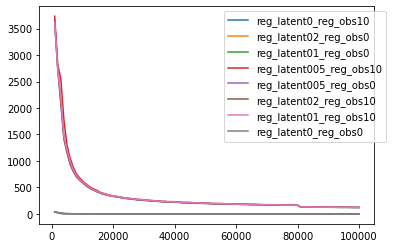

In [39]:
print(os.listdir(targpath))

resultlist = os.listdir(targpath)
print(resultlist)


from utils import notebook_utils as nb



for result in resultlist:
    studypath = os.path.join(targpath, result)
    history = nb.read_history(studypath)
    if len(history) > 0:
        plt.plot(history['iteration'], history['train/loss'], label = result)
        print(history['train/loss'][-1])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig(os.path.join(jobpath, f"""{targdir}_learning.png"""))
print(targdir)

In [38]:
reload(ev)
results = {} 
inferred_Ms = {} 
model_configs = {}
models = {}
tp = 17
n_cond = 2
device =0
predictive = False
reconstructive = False
repeats=3

#targdir_pathlist = [os.path.join(targpath, targdir) for targdir in targlist] 
targdir_pathlist = []
targdir_pathlist.append(playground_path)
#targdir_pathlist.append(basestar_path)
#targdir_pathlist.append(baseline_path)



for targdir_path in targdir_pathlist:
    
    Mlist = [] 
    if os.path.exists(os.path.join(targdir_path, 'config.yml')):
        config = load_config(targdir_path)
    else:
        config = load_config(baseline_path)
        
    dataconfig = config['train_data']
    dataconfig['args']['T'] = tp + n_cond
    dataconfig['args']['train'] = False
#     dataconfig['args']['max_angle_velocity_ratio'] = [-0.2, 0.2]
#     dataconfig['args']['max_color_velocity_ratio'] = [-0.2, 0.2]

    data = yu.load_component(dataconfig)
    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])

    model_config = config['model']
    model = yu.load_component(model_config)
    iterlist = iter_list(targdir_path)

    if len(iterlist) == 0:
        print(f"""There is no model trained for {targdir_path}""")
    else:
        maxiter = np.max(iter_list(targdir_path))
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)

        images = iter(train_loader).next()

        # Initialize lazy modules
        if type(images) == list:
            images = torch.stack(images)
            images = images.transpose(1, 0)        
        images = images.to(device)
        if str(type(model)).split(' ')[-1].split('.')[-1].split("'")[0] == 'SeqAENeuralM_latentPredict':
            model.conduct_prediction(images[:, :n_cond], n_rolls=tp)
        else:
            model(images[:, :n_cond])
            
            
        with torch.no_grad():
            l2scores = []
            for j in range(repeats):
                for images in tqdm(train_loader):
                    if type(images) == list:
                        images = torch.stack(images)
                        images = images.transpose(1, 0)
                    # n t c w h
                    images = images.to(device)
                    images_cond = images[:, :n_cond]
                    if predictive == True or reconstructive == True:
                        images_target = images
                    else:
                        images_target = images[:, n_cond:n_cond+tp]
                    x_next, M = ev.predict(images, model, n_cond=n_cond, tp=tp, device=device, predictive=predictive, reconstructive=reconstructive)

                    #                 l2_losses = []
                    #                 for k in range(tp):

                    #                     images_target_vec = rearrange(images_target, 'n t c w h -> n t (c w h)')
                    #                     x_next_vec = rearrange(x_next, 'n t c w h -> n t (c w h)')
                    #                     #l2_loss_t = torch.sqrt(torch.sum((images_target[:, k].to('cpu') - x_next[:, k].to('cpu'))**2, axis=[1,2,3]))
                    #                     l2_loss_t = torch.sum((images_target[:, k].to('cpu') - x_next[:, k].to('cpu'))**2, axis=[1,2,3])
                    #                     #l2_loss_t = torch.mean(l2_loss_t)
                    #                     l2_losses.append(l2_loss_t)
                    #                 l2_losses = torch.stack(l2_losses, axis=1)
                    l2_losses = torch.sum((images_target.to('cpu') - x_next.to('cpu'))**2, axis=[-1,-2,-3])
                    l2scores.append(l2_losses)

                #print(train_loader.dataset.color_v)
                
                Mlist.append(M)
        
                
        Mlist = torch.cat(Mlist)       
        
        l2scores = torch.cat(l2scores)
        av_l2 = torch.mean(l2scores, axis=0)
        av_l2var = torch.std(l2scores, axis=0)
        print(av_l2)
        results[targdir_path] = [av_l2, av_l2var]


        inferred_Ms[targdir_path] = Mlist
        models[targdir_path] = model.to('cpu')
        model_configs[targdir_path] = model_config


    

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220913_playground_model 
 snapshot_model_iter_50000


  6%|▋         | 2/31 [00:01<00:17,  1.64it/s]

tensor([ 3.9669, 10.0644, 24.3989, 31.2530, 42.3946, 44.4998, 51.4195, 62.7080,
        69.5812, 72.5803, 69.7593, 70.3386, 71.5837, 66.0502, 62.4470, 62.6464,
        64.4314])
tensor([ 5.5528, 14.0667, 20.2190, 30.9977, 40.2427, 46.1711, 51.6590, 59.9125,
        65.8715, 63.0975, 71.7425, 75.4647, 74.1148, 69.9347, 65.1632, 65.1035,
        68.0569])


 10%|▉         | 3/31 [00:01<00:10,  2.63it/s]

tensor([ 4.4603,  9.5989, 17.2476, 25.0212, 34.1122, 41.1063, 49.1567, 55.8784,
        61.6107, 65.8591, 65.1189, 65.5092, 61.5737, 64.1751, 63.8899, 61.3339,
        60.9184])
tensor([ 5.6378, 16.6293, 30.5271, 41.5683, 47.9331, 59.1757, 68.7087, 66.7185,
        76.4123, 75.4626, 77.4112, 79.2982, 74.8676, 73.0821, 70.0349, 71.4226,
        64.8302])


 23%|██▎       | 7/31 [00:01<00:04,  5.82it/s]

tensor([ 4.4993, 12.9275, 23.1198, 31.4595, 37.9938, 43.4314, 55.2732, 57.6290,
        59.5827, 61.3843, 63.0960, 65.6196, 57.7237, 56.3248, 57.0869, 49.2616,
        52.7640])
tensor([ 5.2966, 12.5475, 20.7577, 35.3880, 46.6163, 54.1061, 65.0219, 64.8984,
        72.2461, 71.3084, 71.3847, 71.3832, 65.5171, 65.6343, 57.5879, 52.1461,
        55.7625])
tensor([ 3.6670,  8.4904, 19.6213, 30.4278, 40.9214, 52.7976, 59.0527, 64.0574,
        66.3459, 70.5613, 66.5924, 66.2034, 60.5533, 61.8708, 60.4823, 61.6635,
        58.3017])


 29%|██▉       | 9/31 [00:02<00:03,  7.14it/s]

tensor([ 5.5028, 13.1003, 21.6620, 32.7780, 43.1525, 51.0643, 57.3832, 65.7417,
        68.7099, 70.7582, 65.8204, 63.0080, 59.7472, 61.0068, 57.3150, 62.1628,
        62.1284])
tensor([ 4.7310, 10.6695, 20.3479, 34.0549, 41.0872, 59.4664, 65.2148, 65.8903,
        69.4300, 68.7151, 68.3374, 64.9048, 67.2666, 64.9047, 58.5888, 52.6636,
        54.5612])
tensor([ 4.6463,  7.7503, 16.1582, 30.4241, 39.3032, 51.4320, 54.0814, 64.4285,
        67.3899, 68.4569, 66.8066, 65.6347, 65.2504, 60.4713, 54.7888, 55.5858,
        49.3651])


 42%|████▏     | 13/31 [00:02<00:01,  9.02it/s]

tensor([ 6.3537, 15.9562, 27.7885, 37.1052, 43.1510, 53.4279, 58.7752, 66.9341,
        66.9492, 67.7953, 73.5554, 73.2225, 73.6415, 67.7419, 68.4778, 68.1892,
        63.4750])
tensor([ 4.7440, 10.5364, 19.8634, 30.4652, 37.5687, 46.5477, 53.9758, 64.2280,
        62.0788, 64.6313, 66.0448, 68.3929, 60.3882, 63.4887, 59.7599, 59.4437,
        58.4643])
tensor([ 5.6558, 13.5276, 27.3997, 41.4776, 49.5298, 57.3690, 61.8820, 73.5621,
        71.7959, 75.5828, 75.4330, 73.6016, 69.6787, 68.8752, 69.9449, 65.8519,
        65.0375])


 48%|████▊     | 15/31 [00:02<00:01,  9.60it/s]

tensor([ 4.8079,  9.8156, 20.1330, 32.0043, 39.3736, 46.4081, 59.3826, 65.5159,
        68.0201, 71.8657, 70.3034, 72.0603, 68.3158, 63.1399, 56.5671, 56.9768,
        52.3900])
tensor([ 4.2457, 12.3209, 23.8904, 34.9160, 43.3159, 50.1873, 54.5279, 59.7200,
        72.2645, 72.8409, 76.9163, 74.3605, 67.8993, 69.8162, 71.3238, 62.5072,
        55.8550])
tensor([ 4.9558, 14.3459, 25.0804, 33.0335, 42.7159, 50.7964, 58.7261, 66.1422,
        69.4005, 66.7332, 72.8414, 64.9112, 64.3009, 64.3453, 63.9836, 60.1117,
        60.8563])


 61%|██████▏   | 19/31 [00:03<00:01, 10.30it/s]

tensor([ 6.5323, 14.3441, 27.5247, 36.8915, 44.4358, 49.4908, 55.1519, 57.7495,
        63.4111, 60.1726, 64.2810, 61.3054, 61.8260, 62.3547, 57.6536, 59.7505,
        62.9774])
tensor([ 4.6484, 12.7836, 27.0720, 40.3634, 43.7821, 50.5989, 60.0131, 65.8064,
        69.5505, 71.7383, 70.1026, 64.8677, 66.5760, 60.4471, 64.0574, 58.4867,
        53.6178])
tensor([ 4.9994, 10.3846, 22.4267, 34.5936, 37.2339, 49.8062, 54.3279, 61.5841,
        62.7683, 68.1602, 67.8886, 68.6291, 66.1519, 62.3706, 61.5941, 62.0605,
        59.0874])


 68%|██████▊   | 21/31 [00:03<00:00, 10.45it/s]

tensor([ 4.1052, 11.2307, 21.5100, 28.3976, 38.1222, 49.9751, 58.3947, 64.5336,
        70.1258, 74.8991, 70.6096, 71.3561, 70.6461, 69.2902, 61.1012, 59.6796,
        60.9246])
tensor([ 5.1912, 11.1921, 18.8466, 26.8100, 34.4581, 42.3825, 48.2712, 56.0147,
        60.9745, 63.9195, 70.0847, 69.6817, 65.0292, 61.4035, 56.7365, 55.2093,
        57.0341])
tensor([ 4.2541, 11.0941, 21.9737, 32.3442, 37.8181, 50.6535, 58.8793, 63.0799,
        63.2712, 63.8322, 64.1253, 64.8472, 63.5833, 63.8142, 62.9836, 64.7370,
        60.3832])


 81%|████████  | 25/31 [00:03<00:00, 10.72it/s]

tensor([ 4.9154, 14.6085, 25.4861, 35.1540, 41.2601, 51.6949, 55.8156, 62.8024,
        65.7382, 63.2304, 67.4973, 63.5834, 69.1104, 63.6829, 58.9996, 60.8805,
        62.8003])
tensor([ 4.6095, 15.7748, 23.8644, 34.9946, 47.4007, 51.8488, 58.6607, 63.1170,
        72.1774, 78.5751, 73.9879, 72.4280, 74.0145, 70.3797, 66.9391, 62.7236,
        60.2538])
tensor([ 4.7526, 13.4596, 24.2237, 37.3079, 49.7301, 58.7491, 64.1762, 68.4625,
        68.5213, 68.2166, 68.9935, 68.0283, 68.9901, 66.3503, 58.1830, 57.9900,
        61.8501])


 87%|████████▋ | 27/31 [00:03<00:00, 10.74it/s]

tensor([ 4.9190, 10.1131, 19.9750, 30.7512, 40.8405, 46.4142, 55.4286, 59.0419,
        59.1224, 65.3704, 62.9846, 64.9685, 63.9037, 57.5282, 59.1131, 57.3929,
        55.7549])
tensor([ 4.9908, 13.5420, 23.4121, 34.5937, 42.7503, 52.4758, 59.6629, 68.1366,
        73.9905, 81.1029, 79.4292, 74.3522, 74.3513, 72.2444, 67.2352, 65.5601,
        59.7834])
tensor([ 5.0172, 10.6127, 20.3670, 27.3303, 37.8937, 44.0054, 50.6295, 60.2045,
        63.0807, 67.9981, 68.4424, 67.7344, 58.8599, 58.5942, 52.7678, 54.6047,
        51.1271])


100%|██████████| 31/31 [00:04<00:00, 10.68it/s]

tensor([ 6.1820, 12.5646, 20.8733, 30.6478, 42.9025, 50.9773, 61.2030, 62.6348,
        70.2739, 69.7934, 67.7977, 67.0210, 61.7133, 62.7197, 63.0348, 58.6692,
        57.3686])
tensor([ 5.1168, 11.0859, 21.2193, 31.6721, 42.9118, 51.1638, 56.4585, 71.2145,
        71.3921, 72.9232, 69.8439, 62.0100, 64.7562, 60.9161, 57.8905, 51.4486,
        56.2504])
tensor([ 6.5258, 14.4925, 23.2562, 32.6965, 44.2651, 51.7074, 59.3380, 58.7829,
        63.2967, 76.0969, 70.9387, 74.4332, 68.2793, 62.8353, 67.4912, 67.4687,
        62.3117])


 10%|▉         | 3/31 [00:01<00:10,  2.68it/s]

tensor([ 4.2127, 11.2234, 20.6204, 27.6174, 41.5138, 46.6410, 55.0039, 60.5651,
        63.2095, 59.5468, 60.2711, 63.4125, 57.9408, 56.3427, 52.9891, 57.4280,
        52.5568])
tensor([ 3.5743,  8.4862, 15.3438, 23.2834, 30.6230, 39.0973, 46.4770, 54.7556,
        58.2612, 67.6773, 64.7484, 66.3512, 67.2860, 61.3661, 61.6387, 59.3743,
        59.8686])
tensor([ 3.8411, 12.2471, 21.5847, 34.6216, 44.7382, 56.0636, 61.9661, 65.1304,
        69.0219, 71.6935, 66.5186, 69.1247, 67.1137, 62.7205, 60.5685, 59.0523,
        50.9257])


 16%|█▌        | 5/31 [00:01<00:06,  4.31it/s]

tensor([ 7.1888, 13.8310, 24.1183, 36.5531, 47.4370, 51.5202, 60.2040, 60.3481,
        69.2490, 64.2363, 72.0270, 62.8407, 59.3947, 57.5201, 57.2330, 54.8114,
        52.6702])
tensor([ 6.1135, 13.7292, 23.1329, 31.7689, 38.1776, 44.2592, 52.7046, 64.6261,
        68.4871, 69.1523, 69.4473, 64.1374, 68.5622, 67.0236, 66.7921, 71.0813,
        64.4852])
tensor([ 5.5497, 12.6248, 21.2014, 26.1580, 44.4688, 46.1723, 53.3963, 56.0537,
        57.7584, 60.0127, 70.6564, 68.3034, 70.7042, 67.8108, 68.5104, 67.4100,
        65.0029])


 23%|██▎       | 7/31 [00:01<00:04,  5.78it/s]

tensor([ 4.7186, 12.3477, 19.8749, 32.5810, 41.7754, 48.6351, 56.6801, 69.2823,
        70.9184, 71.6748, 74.8222, 69.4966, 62.4332, 60.1854, 56.4400, 54.5493,
        48.6704])
tensor([ 4.3508, 12.8522, 25.3306, 34.9041, 42.8743, 51.2795, 55.6552, 64.3867,
        64.4159, 65.5302, 67.3614, 66.1842, 67.7387, 61.1758, 58.5394, 53.6981,
        50.2479])


 35%|███▌      | 11/31 [00:02<00:02,  7.96it/s]

tensor([ 4.5429,  9.1759, 18.0439, 28.6077, 40.8666, 46.7097, 56.1673, 60.6046,
        70.6140, 73.2282, 73.3987, 78.1161, 77.1772, 73.0995, 65.7311, 68.1779,
        61.8377])
tensor([ 5.1547, 15.0263, 29.5447, 35.8562, 50.3869, 55.5863, 63.0778, 74.1796,
        74.0086, 78.1805, 74.0707, 75.6209, 68.1291, 60.8784, 63.8899, 59.0756,
        55.3988])
tensor([ 5.0289, 12.5461, 26.9132, 35.3866, 41.5493, 53.7355, 58.0180, 67.6417,
        61.8110, 67.1909, 71.8159, 67.6277, 65.9469, 68.2258, 67.6254, 64.3084,
        63.5820])


 42%|████▏     | 13/31 [00:02<00:02,  8.83it/s]

tensor([ 4.8419, 14.1676, 22.5323, 33.7524, 40.5841, 49.1383, 58.1804, 63.8241,
        66.2731, 66.5608, 67.2745, 65.3050, 63.5838, 63.3510, 62.0280, 59.4782,
        58.3995])
tensor([ 4.9216, 15.0697, 29.1295, 36.8881, 49.4565, 58.3003, 68.5236, 69.0147,
        69.5653, 74.3812, 69.5191, 67.5945, 63.4636, 61.0487, 60.8345, 59.9055,
        60.8022])
tensor([ 4.7251, 10.5082, 20.8422, 30.3044, 36.5184, 42.1675, 51.5809, 61.6505,
        63.8379, 61.9885, 63.5723, 60.6244, 61.0918, 64.5567, 62.0408, 64.1564,
        60.8549])


 55%|█████▍    | 17/31 [00:02<00:01, 10.12it/s]

tensor([ 4.4343, 14.2182, 26.6913, 35.5284, 45.5596, 48.4018, 65.2203, 65.2453,
        66.6465, 71.4090, 62.8336, 62.0400, 61.0706, 55.6329, 56.1292, 59.2301,
        53.7754])
tensor([ 4.0812, 11.4741, 23.7692, 38.5007, 47.9778, 56.0878, 65.5836, 71.7008,
        69.6792, 72.6665, 75.3803, 67.1057, 66.0513, 59.2691, 60.1647, 58.2494,
        59.1754])
tensor([ 5.4868, 15.6069, 28.3734, 40.3328, 48.0662, 52.4793, 56.2071, 65.6847,
        62.9620, 66.4902, 65.7659, 61.0058, 53.9650, 57.6832, 55.3599, 50.5967,
        55.1383])


 61%|██████▏   | 19/31 [00:02<00:01, 10.44it/s]

tensor([ 5.4343, 11.8456, 19.7819, 30.3313, 39.5129, 49.5121, 55.5169, 62.4920,
        68.6988, 73.8536, 70.5942, 75.4410, 68.7526, 74.9389, 68.7900, 64.1490,
        60.7842])
tensor([ 3.8162,  8.9268, 18.3875, 29.7104, 38.3505, 47.7722, 49.2873, 58.8408,
        61.0937, 62.4837, 64.3526, 63.0757, 68.9570, 62.3066, 57.9634, 59.4187,
        55.4375])
tensor([ 5.8270, 13.5690, 22.8304, 32.7418, 38.3002, 48.5658, 55.2140, 65.1353,
        70.7749, 71.2249, 64.1542, 67.1747, 68.6198, 61.7366, 60.7618, 58.7467,
        55.7400])


 74%|███████▍  | 23/31 [00:03<00:00, 10.81it/s]

tensor([ 4.7976, 12.0947, 22.7848, 32.3029, 41.3572, 52.2374, 55.8067, 63.9608,
        70.5498, 70.6722, 66.4567, 68.3008, 67.9921, 69.5024, 62.7457, 66.3021,
        60.7055])
tensor([ 4.0847,  9.3927, 20.5382, 32.0796, 38.8051, 49.0286, 52.5880, 65.8708,
        71.8028, 69.1425, 71.0979, 67.4728, 62.7861, 61.7633, 61.0437, 59.9271,
        59.2268])
tensor([ 4.5908, 11.0375, 21.1115, 29.5852, 44.6060, 52.9910, 59.3185, 64.3964,
        68.0949, 71.7335, 69.6395, 61.7810, 55.3752, 56.0080, 52.0237, 53.1342,
        51.0366])


 81%|████████  | 25/31 [00:03<00:00, 11.00it/s]

tensor([ 4.4491,  8.6657, 16.8438, 27.3695, 34.8627, 47.4612, 57.3251, 58.7930,
        63.6597, 62.6509, 68.9536, 66.4216, 59.5891, 59.5378, 57.9432, 55.6498,
        55.9306])
tensor([ 4.5943,  7.8187, 13.7154, 23.3286, 33.7829, 42.3912, 52.0636, 61.8502,
        66.1501, 69.1686, 72.5852, 72.4018, 68.7404, 71.1852, 68.5772, 65.8325,
        60.1961])
tensor([ 4.0547, 10.1094, 21.4679, 26.2083, 37.3646, 44.5916, 54.9915, 58.6982,
        63.9662, 69.2168, 70.0223, 73.9528, 68.0618, 67.1015, 64.6163, 64.7719,
        60.9769])


 94%|█████████▎| 29/31 [00:03<00:00, 11.24it/s]

tensor([ 4.1696,  9.9037, 20.3226, 32.1728, 37.8812, 49.3095, 57.5624, 63.6689,
        72.6219, 75.0877, 69.5857, 76.7757, 66.9987, 69.7188, 68.5851, 65.9084,
        61.8681])
tensor([ 5.7217, 13.7550, 24.4507, 33.1157, 44.4876, 51.1903, 56.4017, 63.3787,
        65.8220, 74.6664, 66.4167, 60.9311, 63.5380, 61.5720, 62.4332, 62.6286,
        60.7099])
tensor([ 4.1124,  9.1963, 21.6854, 32.0256, 36.8630, 50.3027, 60.3837, 63.8810,
        64.0952, 64.8173, 62.4328, 65.2684, 65.3510, 61.8961, 62.7587, 64.6913,
        65.7380])


100%|██████████| 31/31 [00:03<00:00, 11.05it/s]

tensor([ 4.9874, 10.9209, 20.8554, 30.3174, 36.6767, 48.5162, 57.3002, 59.6902,
        65.8906, 66.1189, 63.2029, 60.7290, 59.5601, 60.2774, 56.5003, 52.2915,
        50.0400])
tensor([ 4.5550, 13.0923, 28.3239, 34.5522, 44.2029, 46.0273, 55.3493, 66.2067,
        70.2958, 70.6508, 74.4068, 63.3213, 67.9086, 54.1683, 56.2111, 48.2700,
        49.9559])


  6%|▋         | 2/31 [00:01<00:16,  1.81it/s]

tensor([ 4.0735,  8.9523, 20.5980, 28.3501, 34.1268, 39.0922, 48.1372, 53.7789,
        52.8243, 53.7756, 57.9706, 55.4227, 54.5925, 60.1714, 60.1997, 56.9940,
        57.2533])
tensor([ 6.1441, 15.7605, 29.5674, 40.6501, 46.5620, 55.3064, 61.9862, 72.5116,
        77.5032, 80.8864, 76.5344, 73.6739, 77.4508, 79.3095, 70.0536, 66.6857,
        67.2782])


 16%|█▌        | 5/31 [00:01<00:05,  4.80it/s]

tensor([ 4.8809, 11.3338, 19.2193, 24.2671, 28.0974, 40.4831, 47.8292, 53.9048,
        60.8210, 65.2367, 63.2499, 66.5093, 64.7262, 63.7669, 64.4030, 58.8904,
        56.0724])
tensor([ 4.2686, 10.7554, 21.8477, 32.8116, 42.7981, 53.3487, 57.4499, 65.7097,
        73.5943, 68.6194, 70.2694, 68.7603, 63.2024, 57.3231, 58.3129, 56.3083,
        55.1263])
tensor([ 5.1533, 11.8965, 22.2751, 32.8631, 43.2484, 50.3323, 57.1260, 61.4832,
        61.9392, 70.8109, 70.1968, 71.1434, 70.5469, 72.2295, 67.6679, 66.8092,
        64.0780])


 23%|██▎       | 7/31 [00:01<00:03,  6.26it/s]

tensor([ 4.3290,  9.6669, 19.0894, 29.9243, 41.9560, 47.6758, 54.6352, 62.1886,
        61.7533, 66.7913, 64.9539, 64.9253, 60.5757, 53.4157, 52.0302, 50.6619,
        45.1267])
tensor([ 5.0662, 11.8972, 21.5216, 35.9588, 41.4599, 52.2539, 60.4487, 70.3879,
        73.6926, 71.1249, 76.1458, 73.2336, 65.2201, 64.6225, 60.7856, 58.0070,
        55.5393])
tensor([ 3.6955,  9.6355, 22.3957, 30.4263, 45.1759, 50.9838, 56.4048, 70.0978,
        71.4456, 70.1494, 69.4207, 65.3783, 65.2838, 65.3030, 60.8279, 56.3671,
        50.9438])


 35%|███▌      | 11/31 [00:02<00:02,  8.37it/s]

tensor([ 6.1924, 13.6619, 22.5588, 31.4041, 44.1377, 50.5924, 60.6778, 64.9767,
        75.8600, 73.8128, 72.3358, 75.8214, 67.6937, 63.3003, 64.2851, 59.1025,
        62.8170])
tensor([ 3.7350,  8.2289, 18.4476, 32.0923, 46.3354, 55.6033, 62.6350, 66.1205,
        70.0984, 75.4218, 74.6874, 74.3423, 64.7426, 60.7208, 57.9151, 53.8589,
        54.0257])
tensor([ 5.3443, 16.2260, 25.3106, 36.1088, 38.6336, 49.4590, 58.0707, 60.4575,
        62.8061, 65.8130, 66.7457, 69.1440, 67.7251, 65.0524, 67.8066, 69.0705,
        67.6771])


 42%|████▏     | 13/31 [00:02<00:01,  9.14it/s]

tensor([ 4.5918, 11.6436, 20.2199, 29.8792, 43.6298, 53.6986, 57.9981, 66.8061,
        71.5304, 72.1558, 69.6233, 73.6081, 72.3892, 70.6297, 70.6586, 69.0530,
        66.4272])
tensor([ 5.1768, 13.3038, 19.8928, 30.1972, 47.6051, 57.3736, 63.7495, 68.5336,
        75.5571, 72.7623, 79.2527, 80.6151, 75.0291, 75.4078, 70.0761, 68.9832,
        60.7617])
tensor([ 5.1572, 15.2937, 26.0953, 36.3470, 43.2259, 52.7801, 58.0067, 67.6916,
        64.3435, 63.0059, 63.3085, 62.7773, 60.1421, 55.5942, 56.8531, 52.0089,
        51.4581])


 55%|█████▍    | 17/31 [00:02<00:01, 10.30it/s]

tensor([ 4.9833, 13.2846, 23.5300, 36.0819, 40.8133, 51.0969, 60.9405, 71.6150,
        68.4056, 66.2461, 73.7116, 62.4704, 67.5103, 65.2263, 58.8143, 59.6199,
        60.0575])
tensor([ 5.3449, 15.0765, 27.6645, 39.4125, 44.8701, 57.8705, 61.4720, 71.1089,
        78.1350, 81.2802, 82.0369, 71.3799, 79.1740, 72.6188, 74.2096, 72.4036,
        65.3443])
tensor([ 4.6369, 11.8201, 20.2829, 29.7402, 46.3541, 51.6036, 62.1781, 64.7682,
        72.3140, 77.7770, 72.3259, 68.8400, 71.1856, 71.0760, 68.8792, 65.1292,
        61.8295])


 61%|██████▏   | 19/31 [00:02<00:01, 10.67it/s]

tensor([ 4.5289, 11.8106, 19.6564, 29.0026, 36.7934, 47.0370, 51.6175, 55.7454,
        64.2791, 69.2261, 63.1006, 66.4635, 67.0246, 63.0133, 60.5396, 59.6802,
        58.5899])
tensor([ 5.6779, 12.1877, 22.5941, 38.8023, 47.1990, 53.6523, 61.2710, 66.7736,
        69.3702, 74.1782, 74.4602, 75.9165, 72.8988, 70.2929, 65.9658, 64.6722,
        65.5982])
tensor([ 4.4642, 13.1108, 23.6569, 33.1689, 40.3201, 49.8710, 61.5293, 66.1866,
        66.9234, 71.8157, 77.6728, 73.6442, 77.1337, 68.4259, 69.0449, 61.4259,
        56.6729])


 74%|███████▍  | 23/31 [00:03<00:00, 11.00it/s]

tensor([ 6.4499, 12.3607, 20.1593, 30.3646, 38.7741, 45.3628, 53.6751, 57.3841,
        62.7257, 67.8053, 72.7517, 75.4025, 75.0857, 74.5045, 71.1957, 73.4948,
        70.5302])
tensor([ 5.3334, 12.5734, 26.0690, 39.6916, 42.5206, 48.3338, 56.3289, 60.9322,
        62.8997, 71.0705, 64.7394, 65.6135, 62.2078, 69.8951, 61.1025, 56.2931,
        62.4193])
tensor([ 3.8258,  9.9877, 20.1078, 28.8025, 35.4983, 46.7495, 50.5692, 57.8902,
        59.6775, 58.9185, 60.6205, 63.4237, 63.3666, 58.9493, 59.2090, 56.3977,
        54.8658])


 81%|████████  | 25/31 [00:03<00:00, 11.01it/s]

tensor([ 4.8658, 11.3059, 23.2028, 36.5425, 48.2424, 60.9909, 70.3414, 64.5666,
        71.2507, 71.6519, 66.2784, 64.9209, 56.6333, 54.6551, 51.5062, 45.5726,
        40.3326])
tensor([ 4.9445, 13.1453, 26.7367, 34.8826, 44.3088, 52.8310, 62.9862, 64.2029,
        67.0811, 64.7139, 72.2584, 71.9339, 67.2339, 61.9902, 61.0768, 56.6732,
        53.8034])
tensor([ 5.5892, 14.7917, 22.5422, 30.4888, 42.2441, 45.5208, 56.3040, 62.6309,
        67.1164, 73.9689, 69.5205, 72.0058, 73.7563, 77.7792, 70.7415, 66.0590,
        70.3792])


 94%|█████████▎| 29/31 [00:03<00:00, 11.16it/s]

tensor([ 6.2270, 11.6517, 24.6441, 36.9133, 44.5438, 52.0649, 57.8202, 71.3730,
        74.6513, 71.9961, 65.2777, 66.7261, 67.2475, 61.8253, 59.3370, 57.0776,
        50.2228])
tensor([ 4.1829, 11.8056, 20.0757, 35.2871, 42.5823, 49.7351, 55.1888, 67.5515,
        66.8893, 67.9501, 68.6981, 67.8101, 69.4124, 62.8499, 62.5171, 64.2515,
        60.6773])
tensor([ 5.1113, 11.9616, 23.9678, 33.0728, 45.3796, 56.7099, 65.1096, 74.4345,
        73.4504, 79.9261, 72.1952, 67.0445, 67.4995, 67.1939, 63.4852, 58.5858,
        60.6348])


100%|██████████| 31/31 [00:03<00:00, 10.92it/s]

tensor([ 5.6803, 14.6627, 23.5638, 33.5364, 47.8413, 49.5214, 62.3305, 67.9972,
        79.4320, 77.0303, 75.8098, 74.6057, 69.8593, 63.2999, 64.0393, 64.7810,
        60.3098])
tensor([ 5.4169, 11.6787, 22.9858, 29.1383, 40.2847, 49.1514, 53.2986, 57.7740,
        60.8479, 60.8350, 69.1815, 60.4801, 67.4151, 63.8289, 57.3683, 52.3369,
        54.4753])


100%|██████████| 31/31 [00:04<00:00,  7.53it/s]


tensor([ 4.9245, 12.1037, 22.4583, 32.7114, 41.8213, 50.1538, 57.5699, 63.9691,
        67.4984, 69.5034, 69.4077, 68.3143, 66.4161, 64.3384, 62.0775, 60.2935,
        58.4351])


In [31]:
results

{'/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220913_playground_model': [tensor([ 4.8373, 11.5571, 22.1236, 31.9414, 41.2942, 48.9847, 56.7725, 62.8983,
          66.3549, 67.9692, 68.3746, 67.7851, 66.4139, 64.6625, 63.3618, 61.1458,
          58.6782]),
  tensor([ 4.1164, 10.7606, 19.2884, 22.6773, 26.3359, 27.7112, 29.3727, 30.1382,
          29.2872, 28.3199, 28.3122, 28.0896, 29.2356, 29.7891, 30.2383, 30.4785,
          30.8329])]}

In [32]:
l2scores.shape

torch.Size([2946, 17])

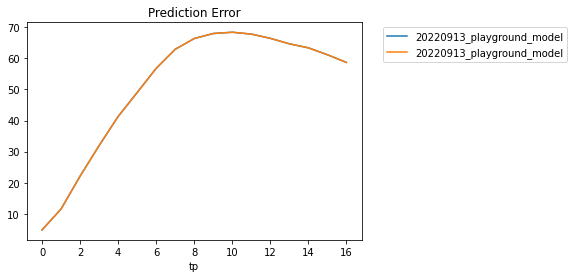

In [33]:
reload(nb)
showresults = []
showresults = nb.filter_queries([''] , list(results.keys()))
#showresults = nb.filter_queries(['predictiveTrue', 'default', 'reg_obs10'] , list(results.keys()))
#showresults = nb.filter_queries([''] , list(results.keys()))

#showresults.append(baseline_path)
showresults.append(playground_path)
#showresults.append(basestar_path)


for mode in showresults:
    plt.plot(results[mode][0], label=mode.split('/')[-1])
    plt.xlabel("tp")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Prediction Error")

plt.savefig(os.path.join(jobpath, targdir+'l2loss.png'))


In [34]:
reload(ev)


def get_predict(targdir_path, swap=False, predictive=False):
    if os.path.exists(os.path.join(targdir_path, 'config.yml')):
        config = load_config(targdir_path)
    else:
        config = load_config(baseline_path)
    
    #config = load_config(targdir_path)

    model_config = config['model']
    if len(iter_list(targdir_path)) > 0:
        maxiter = np.max(iter_list(targdir_path))
        model = yu.load_component(model_config).to(device)
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)
        #model(images[:, :2])
        if str(type(model)).split(' ')[-1].split('.')[-1].split("'")[0] == 'SeqAENeuralM_latentPredict':
            model.conduct_prediction(images[:, :n_cond], n_rolls=tp)
        else:
            model(images[:, :n_cond])
        x_next, M = ev.predict(images, model, n_cond=n_cond, tp=tp, device=device, swap=swap, 
                              predictive=predictive)
        return x_next,M 
    else:
        return 0, 0



In [35]:
from models import seqae
import models
print(seqae.SeqAELSTSQ)
str(type(model)).split(' ')[-1].split('.')[-1].split("'")[0]



<class 'models.seqae.SeqAELSTSQ'>


'SeqAELSTSQ'

/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220913_playground_model 
 snapshot_model_iter_50000
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220913_playground_model 
 snapshot_model_iter_50000


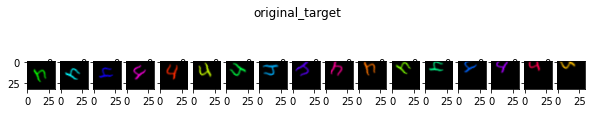

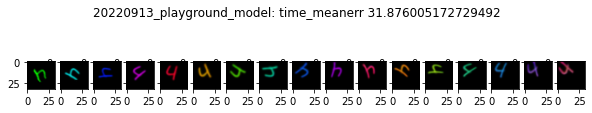

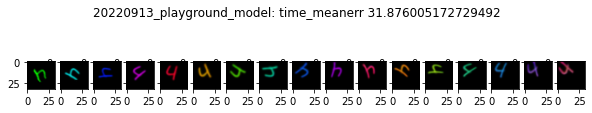

In [36]:
idx = 0
predictive = True

images = data[idx]
if type(images) == list:
    images = torch.stack(images)
    images = images.unsqueeze(0)   
    images= images.to(device)

if predictive == True:
    images_target = images
else:
    images_target = images[:, n_cond:n_cond+tp]
    
plt.figure(figsize=(10,2))
for k in range(0,tp):
    plt.subplot(1,tp, k+1)
    plt.imshow(images_target[0][k].detach().to('cpu').permute([1,2, 0]))
    
plt.suptitle("original_target")
plt.savefig(os.path.join(jobpath, f"""{targdir}_realization_original.png"""))

#for j in range(len(targdir_pathlist)):'
for j in range(len(showresults)):
    #x_next, M = get_predict(targdir_pathlist[j], predictive=predictive)
    x_next, M = get_predict(showresults[j], predictive=predictive)
    if type(x_next) == int:
        pass
    else:
        #name = targdir_pathlist[j].split('/')[-1]
        name = showresults[j].split('/')[-1]
        err=0
        plt.figure(figsize=(10,2))
        for k in range(0,tp): 
            plt.subplot(1,tp, k+1)
            plt.imshow(x_next[0][k].detach().to('cpu').permute([1,2, 0]))
            #err = err + torch.sqrt(torch.sum((x_next[0][k].to('cpu') - images_target[0][k].to('cpu'))**2))
            err = err + torch.sum((x_next[0][k].to('cpu') - images_target[0][k].to('cpu'))**2)
        err = err / (k+1)
        plt.suptitle(f"""{name}: time_meanerr {err}""")
        plt.savefig(os.path.join(jobpath, f"""{targdir}_realization_{name}.png"""))

# x_next, M = get_predict(targlist[1])


# plt.figure()
# for k in range(0,tp): 
#     plt.subplot(1,tp, k+1)
#     plt.imshow(x_next[0][k].detach().to('cpu').permute([1,2, 0]))
# plt.title(targlist[1])






# Equivariance (this should be higher than prediction error, look over

In [19]:
showresults = []
#showresults = nb.filter_queries(['reg_obs10','reg_latent005' ] , list(results.keys()))
#showresults = nb.filter_queries(['predictiveTrue', 'default', 'reg_obs10'] , list(results.keys()))
#showresults = nb.filter_queries([''] , list(results.keys()))

showresults.append(baseline_path)
showresults.append(basestar_path)
showresults.append(playground_path)

In [24]:
equiv_results = {} 
inferred_Ms = {} 
tp = 8
n_cond = 2
repeats = 5
#targdir_pathlist = [os.path.join(targpath, targdir) for targdir in targlist] 
targdir_pathlist = []
targdir_pathlist.append(playground_path)
targdir_pathlist.append(basestar_path)
targdir_pathlist.append(baseline_path)


for targdir_path in targdir_pathlist:


    Mlist = [] 
    if os.path.exists(os.path.join(targdir_path, 'config.yml')):
        config = load_config(targdir_path)
    else:
        config = load_config(baseline_path)
    
    dataconfig = config['train_data']
    dataconfig['args']['train'] = False
#     dataconfig['args']['max_angle_velocity_ratio'] = [-0.2, 0.2]
#     dataconfig['args']['max_color_velocity_ratio'] = [-0.2, 0.2]
    dataconfig['args']['shared_transition'] = 1
    dataconfig['args']['T'] = tp + n_cond
    
    data = yu.load_component(dataconfig)
    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])
    model = yu.load_component(config['model'])
    iterlist = iter_list(targdir_path)
    
    if len(iterlist) == 0:
         print(f"""There is no model trained for {targdir_path}""")
    else:
        maxiter = np.max(iter_list(targdir_path))
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)

        # Initialize lazy modules
        images = iter(train_loader).next()
        # Initialize lazy modules
        if type(images) == list:
            images = torch.stack(images)
            images = images.transpose(1, 0)
        
        images = images.to(device)

        if str(type(model)).split(' ')[-1].split('.')[-1].split("'")[0] == 'SeqAENeuralM_latentPredict':
            model.conduct_prediction(images[:, :n_cond], n_rolls=tp)
        else:
            model(images[:, :n_cond])        
        
        with torch.no_grad():
            l2scores = []
            
            for j in range(repeats):
                for images in tqdm(train_loader):

                    if type(images) == list:
                        images = torch.stack(images)
                        images = images.transpose(1, 0)   
                    # n t c w h
                    images = images.to(device)
                    images_cond = images[:, :n_cond]
                    images_target = images[:, n_cond:n_cond+tp]

                    x_next_perm, M  = ev.predict(images, model, n_cond=n_cond, tp=tp, device=device, swap=True)

                    l2_losses= torch.sum((images_target.to('cpu') - x_next_perm.to('cpu'))**2, axis=[-1,-2,-3])
                    l2scores.append(l2_losses)

                    Mlist.append(M)

                    train_loader.dataset.init_shared_transition_parameters()
                    #print(train_loader.dataset.angles_v)
                    #print(train_loader.dataset.color_v)

                
        Mlist = torch.cat(Mlist)       
        scores = torch.cat(l2scores)
        print(l2_losses.shape)
        print(scores.shape)
        av_score = torch.mean(scores, axis=0)
        av_std = torch.std(scores, axis=0)
        print(f"""mean: {av_score}""")
        print(f"""std: {av_std}""")
        equiv_results[targdir_path] = [av_score, av_std]
        inferred_Ms[targdir_path] = Mlist 


    

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220913_playground_model 
 snapshot_model_iter_50000


100%|██████████| 31/31 [00:02<00:00, 12.65it/s]


torch.Size([22, 8])
torch.Size([4910, 8])
mean: tensor([14.7304, 26.3852, 33.9558, 40.6810, 45.3750, 48.7666, 51.3232, 53.1233])
std: tensor([14.6708, 22.4212, 24.8326, 27.5893, 29.2401, 31.0759, 30.4705, 30.4286])
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_NeuralMstar_neuralM_vanilla 
 snapshot_model_iter_50000


100%|██████████| 31/31 [00:02<00:00, 11.71it/s]


torch.Size([22, 8])
torch.Size([4910, 8])
mean: tensor([76.5088, 81.4737, 87.9259, 87.8629, 88.1768, 87.6833, 85.0533, 80.3951])
std: tensor([35.5513, 35.1632, 37.4547, 40.7882, 47.3188, 51.5638, 54.4746, 56.8496])
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist 
 snapshot_model_iter_50000


100%|██████████| 31/31 [00:02<00:00, 12.07it/s]

torch.Size([22, 8])
torch.Size([4910, 8])
mean: tensor([30.1979, 49.7805, 60.4836, 67.3045, 68.4681, 69.2555, 72.2939, 72.4363])
std: tensor([22.0570, 26.8055, 28.6263, 28.4979, 28.6473, 29.6743, 32.1848, 33.5753])


In [17]:
dataconfig

{'args': {'T': 10,
  'backgrnd': False,
  'max_T': 9,
  'max_angle_velocity_ratio': [-0.2, 0.2],
  'max_color_velocity_ratio': [-0.2, 0.2],
  'only_use_digit4': True,
  'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST',
  'train': False,
  'shared_transition': 1},
 'fn': './datasets/seq_mnist.py',
 'name': 'SequentialMNIST'}

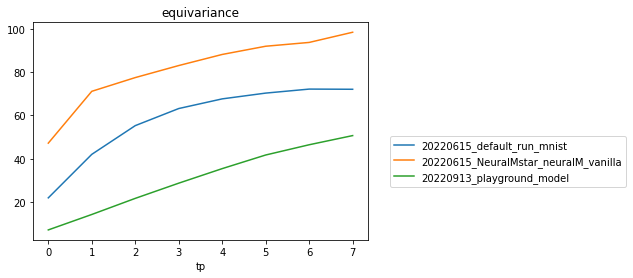

In [20]:
for mode in list(showresults):
    plt.plot(equiv_results[mode][0], label=mode.split('/')[-1])
    plt.xlabel("tp")
plt.legend(loc=0, bbox_to_anchor=(1.05, 0.5))
plt.title("equivariance")
plt.savefig(os.path.join(jobpath, targdir + 'equivariance.png'))


/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist 
 snapshot_model_iter_50000
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_NeuralMstar_neuralM_vanilla 
 snapshot_model_iter_50000
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220913_playground_model 
 snapshot_model_iter_50000


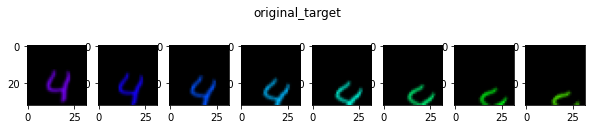

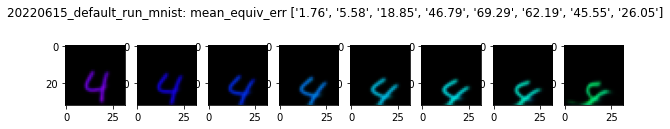

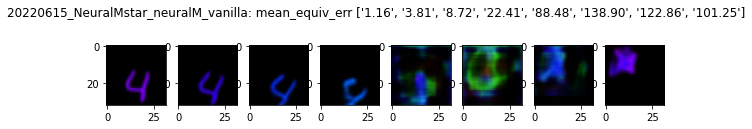

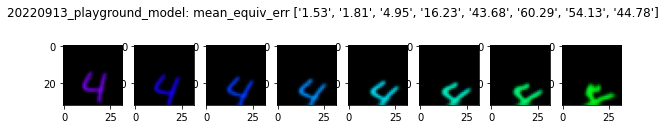

In [22]:
tp=8
idx = 0
#jobpath = os.path.join('../jobs/','_'.join(targdir.split('_')[:-1]))


images = data[idx]
if type(images) == list:
    images = torch.stack(images)
    images = images.unsqueeze(0)   
    images= images.to(device)

images_target = images[:, n_cond:n_cond+tp]

    
plt.figure(figsize =(10,2))
for k in range(0,tp):
    plt.subplot(1,tp, k+1)
    plt.imshow(images_target[0][k].detach().to('cpu').permute([1,2, 0]))
    
plt.suptitle(f"""original_target""")
plt.savefig(os.path.join(jobpath, f"""{targdir}_equiv_original.png"""))

for j in range(len(showresults)):
    x_next, M = get_predict(showresults[j], swap=True)
    name = showresults[j].split('/')[-1]
    plt.figure(figsize =(10,2))
    err = [] 
    for k in range(0,tp): 
        plt.subplot(1,tp, k+1)
        plt.imshow(x_next[0][k].detach().to('cpu').permute([1,2, 0]))
        errval = torch.sum((x_next[0][k].to('cpu') - images_target[0][k].to('cpu'))**2).item()
        err = err + ["{:.2f}".format(errval)]
    #err = err / (k+1)
    plt.suptitle(f"""{name}: mean_equiv_err {err}""")
    plt.savefig(os.path.join(jobpath, f"""{targdir}_equiv_{name}.png"""))

In [32]:
x_next[0][k].shape

torch.Size([3, 32, 32])

In [85]:
os.listdir('/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result')

['20220825_Mstar_variation_0',
 '20220901_Mstar_inv_reg_cnn_0',
 '20220617_default_run_mnist_bg',
 '20220624_Mstar_longer_tp_neuralM_comm',
 '20220621_NeuralMstar_bg_neuralM_vanilla',
 '20220624_Mstar_longer_tp_neuralM_vanilla',
 '20220830_Mstar_orth_0',
 '20220826_Mstar_orth_mlp_two_0',
 '20220831_Mstar_orth_0',
 '20220630_NeuralMstar_comm_0',
 '20220830_Mstar_inv_reg_cnn_0',
 '20220617_NeuralMstar_bg_neuralM_comm',
 '20220628_NeuralMstar_comm_0',
 '20220829_Mstar_inv_reg_0',
 '20220621_NeuralMstar_bg_neuralM_comm',
 '20220816_so3_various_dat_three_0',
 '20220621_so3_rcst_so3run',
 '20220827_Mstar_orth_mlp_two_0',
 '20220615_default_run_mnist',
 '20220615_NeuralMstar',
 '20220615_NeuralMstar_neuralM_vanilla',
 '20220628_pfkube_try_0',
 '20220823_sine_dat_0',
 '20220908_latentPredict_bg_0',
 '20220701_so3_various_dat_three_0',
 '20220901_Mstar_orth_0',
 '20220630_longer_tp_0',
 '20220829_Mstar_inv_reg_cnn_0',
 '20220628_so3_idnet_0',
 '20220611_so3_so3run_rcst',
 '20220628_so3_various_